In [2]:
# Import Libraries
import os
import time
import missingno as msno
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk, re, string, collections, unicodedata

%matplotlib inline
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from datetime import datetime, timedelta
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from langdetect import detect
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from twitterelectionbr.LeIA.leia import SentimentIntensityAnalyzer 


In [3]:
for dirname, _, filenames in os.walk('../raw_data/data_remote/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../raw_data/data_remote/2022/JAIR_BOLSONARO/query_Jair Bolsonaro.csv
../raw_data/data_remote/2022/JAIR_BOLSONARO/query_#bolsonaro.csv
../raw_data/data_remote/2022/JAIR_BOLSONARO/query_(to:jairbolsonaro).csv
../raw_data/data_remote/2022/JAIR_BOLSONARO/query_(from:jairbolsonaro).csv
../raw_data/data_remote/2022/LUIS_INACIO/query_(to:LulaOficial).csv
../raw_data/data_remote/2022/LUIS_INACIO/query_(from:LulaOficial).csv
../raw_data/data_remote/2022/LUIS_INACIO/query_#lula.csv
../raw_data/data_remote/2022/LUIS_INACIO/query_Luis Inácio Lula Da Silva.csv
../raw_data/data_remote/2018/JAIR_BOLSONARO/query_Jair Bolsonaro.csv
../raw_data/data_remote/2018/JAIR_BOLSONARO/query_#bolsonaro.csv
../raw_data/data_remote/2018/JAIR_BOLSONARO/query_(to:jairbolsonaro).csv
../raw_data/data_remote/2018/JAIR_BOLSONARO/query_(from:jairbolsonaro).csv
../raw_data/data_remote/2018/FERNANDO_HADDAD/query_#haddad.csv
../raw_data/data_remote/2018/FERNANDO_HADDAD/query_(from:Haddad_Fernando).csv
../raw_data/data_remote

In [5]:
pd.options.display.max_colwidth = 200

In [6]:
# Reading both the csv files
tweets_dilma = pd.read_csv('../raw_data/data_remote/2014/DILMA_ROUSSEFF/query_#dilma.csv', lineterminator='\n', parse_dates=True)
tweets_aecio = pd.read_csv('../raw_data/data_remote/2014/AECIO_NEVES/query_#aecio.csv', lineterminator='\n', parse_dates=True)

In [7]:
tweets_dilma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104630 entries, 0 to 104629
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   url              104630 non-null  object
 1   date             104630 non-null  object
 2   content          104630 non-null  object
 3   id               104630 non-null  int64 
 4   reply_count      104630 non-null  int64 
 5   retweet_count    104630 non-null  int64 
 6   like_count       104630 non-null  int64 
 7   quote_count      104630 non-null  int64 
 8   lang             104630 non-null  object
 9   username         104630 non-null  object
 10  displayname      104626 non-null  object
 11  description      78229 non-null   object
 12  verified         104630 non-null  bool  
 13  created          104630 non-null  object
 14  followers_count  104630 non-null  int64 
 15  friends_count    104630 non-null  int64 
 16  location         68034 non-null   object
 17  protected 

In [9]:
# Add Features
def normalise(x,y):
    x = np.array(x)
    y = np.array(y)
    return np.where(x == 0, 0, x / y)

def sentiment(data):
    temp=[]
    for row in data:
        tmp=sid.polarity_scores(row)
        temp.append(tmp)
    return temp

In [10]:
#filter columns
tweets_dilma = tweets_dilma[['date', 'content', 'location', 'username', 'retweet_count', 'like_count', 'lang', 'query', 'crawled_date']]
tweets_aecio = tweets_aecio[['date', 'content', 'location', 'username', 'retweet_count', 'like_count', 'lang', 'query', 'crawled_date']]

#removing duplicates
tweets_dilma = tweets_dilma.drop_duplicates(subset=['content'], keep='first')
tweets_aecio = tweets_aecio.drop_duplicates(subset=['content'], keep='first')

#converting date
tweets_dilma['date'] = pd.to_datetime(tweets_dilma['date'])
tweets_dilma['crawled_date'] = pd.to_datetime(tweets_dilma['crawled_date'])
#tweets_dilma['month'] = tweets_dilma['date'].dt.month
#tweets_dilma['year'] = tweets_dilma['date'].dt.year

tweets_aecio['date'] = pd.to_datetime(tweets_aecio['date'])
tweets_aecio['crawled_date'] = pd.to_datetime(tweets_aecio['crawled_date'])
#tweets_aecio['month'] = tweets_aecio['date'].dt.month
#tweets_aecio['year'] = tweets_aecio['date'].dt.year

# normalise likes and retweets to allow fair analysis
b_tdiff=(tweets_dilma['crawled_date'] - tweets_dilma['date'])
t_tdiff=(tweets_aecio['crawled_date'] - tweets_aecio['date'])
b_tdiff=(b_tdiff.dt.days * 24 + b_tdiff.dt.seconds / 3600)
t_tdiff=(t_tdiff.dt.days * 24 + t_tdiff.dt.seconds / 3600)

# Use numpy vectorisation to create new columns for normalised likes and retweets
tweets_dilma['likes_norm'] = normalise(tweets_dilma['like_count'],b_tdiff)
tweets_dilma['retweet_norm'] = normalise(tweets_dilma['retweet_count'],b_tdiff)
tweets_aecio['likes_norm'] = normalise(tweets_aecio['like_count'],t_tdiff)
tweets_aecio['retweet_norm'] = normalise(tweets_aecio['retweet_count'],t_tdiff)

In [11]:
import re
import string
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import  make_column_transformer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords 


class CleaningEncoder(BaseEstimator, TransformerMixin):
    '''
    Receives raw text data from the tweets and returns clean, ready to process data:
    turns all into lower case;
    removes punctuation;
    removes stopwords;
    removes numbers;
    removes users' handles
    
    '''
    def __init__(self):
        pass
                        
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        #assert isinstance(X, pd.DataFrame)
        X_ = X.copy()      
        
        #removin NaN values
        X_ = X_.fillna('nenhuma descrição')
        
        #removing links
        X_ = X_.apply(lambda x: re.sub(r"http\S+", "", x))
        X_ = X_.apply(lambda x: re.sub(r"www.\S+", "", x))
                
        #removing punctuation from each tweet
        new_punc = list(string.punctuation)
        del new_punc[2]
        del new_punc[-11]
        for punctuation in new_punc:
            X_ = X_.str.replace(punctuation, '')
            
        #removing numbers
        X_ = X_.str.replace('\d+', '')
        
        #tokenizing - removes handles, applies lowercase, keeps #, shortens letter repetitions to three
        #ex: kkkkk, kkkkkk, kkkkkkkkk = kkk
        tkn = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
        X_ = X_.apply(lambda x: tkn.tokenize(x))
        
        #removing stopwords
        stop_words = stopwords.words('portuguese')
        stop_words.remove('não')
        addicional = [
            'd', 'ta', 'q', 'tah', 'tao', 'eh', 'vc', 'voce',
            'pq', 'quedê', 'mto', 'mt', 'bj', 'bjs','vcs','bb',
            'b', 'sao', 'axo', 'mano', 'ae', 'neh', 'aí', '...', 'rt',
            'kkk', 'porque', 'né', 'no', 'iai', 'tbm', 'msm', 'jah']
        stop_words.extend(addicional)
        
        #X_ = X_.apply(lambda x: [word for word in x if len(word) > 1])
        X_ = X_.apply(lambda x: [word for word in x if word not in (stop_words)])
        #X_ = X_.apply(lambda x: ' '.join(word for word in x if word not in (stop_words)))
        
        return X_

In [12]:
tweets_dilma.shape

(102296, 11)

In [13]:
tweets_aecio.shape

(35339, 11)

In [14]:
#cleaning data
clean = CleaningEncoder()

tweets_dilma['content_clean'] = clean.fit_transform(tweets_dilma['content'])
tweets_aecio['content_clean'] = clean.fit_transform(tweets_aecio['content'])

/tmp/ipykernel_1914/3828560213.py:43: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_ = X_.str.replace(punctuation, '')
/tmp/ipykernel_1914/3828560213.py:46: FutureWarning: The default value of regex will change from True to False in a future version.
  X_ = X_.str.replace('\d+', '')
/tmp/ipykernel_1914/3828560213.py:43: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_ = X_.str.replace(punctuation, '')
/tmp/ipykernel_1914/3828560213.py:46: FutureWarning: The default value of regex will change from True to False in a future version.
  X_ = X_.str.replace('\d+', '')


In [27]:
# Visualisation args
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap2(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)

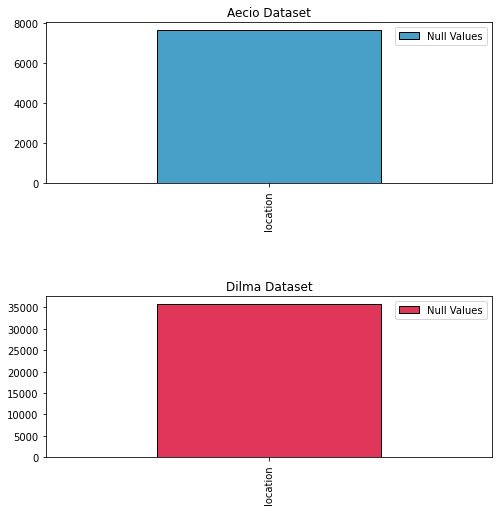

In [29]:
na_vals_b=pd.DataFrame({'Null Values':tweets_aecio.isna().sum()})
na_vals_b=na_vals_b.loc[na_vals_b['Null Values'] > 0]
na_vals_t=pd.DataFrame({'Null Values':tweets_dilma.isna().sum()})
na_vals_t=na_vals_t.loc[na_vals_t['Null Values'] > 0]

# Null values visualisation for tweets about Joe Biden and Donald Trump
fig, ax=plt.subplots(2,1, figsize=(8,8), gridspec_kw={'hspace':0.7})

na_vals_b.plot.bar(color=barcolors[3], **barstyle, ax=ax[0])
ax[0].set_title('Aecio Dataset')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

na_vals_t.plot.bar(color=barcolors[6], **barstyle, ax=ax[1])
ax[1].set_title('Dilma Dataset')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
plt.show()

In [34]:
%%time
def detect_tweetlang(tweet):
    try:
        return detect(tweet)
    except:
        return 'unknown'

# Combine two data files and drop duplicates
lang_df=pd.concat([tweets_aecio[['content','location']].copy(),tweets_dilma[['content','location']].copy()])
#lang_df['country'].replace({'United States of America':'United States'}, inplace=True)
lang_df=lang_df.fillna('Geo Data NA')
lang_df=lang_df.drop_duplicates()

# Randomly sample data for langauge analysis
lang_smdf=lang_df.sample(n=4000).copy()
lang_smdf['lang'] = lang_smdf['content'].apply(detect_tweetlang)

# Select top five languages and five countries for heatmap
langs=pd.DataFrame(lang_smdf.groupby(['lang'])['content'].count().sort_values(ascending=False)[:5])
langs=langs.reset_index()
langslst=langs.lang.to_list()

country=pd.DataFrame(lang_smdf.groupby(['location'])['content'].count().sort_values(ascending=False)[:5])
country=country.reset_index()
countrylst=country.location.to_list()

# Create a crosstab to feed data to heatmap
langXtab=pd.crosstab(lang_smdf.lang, lang_smdf.location, normalize=True)

CPU times: user 36 s, sys: 599 ms, total: 36.6 s
Wall time: 36.5 s


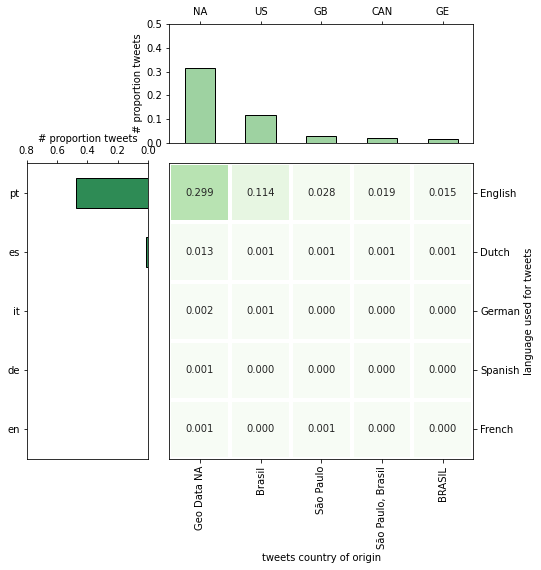

In [44]:
fig, ax=plt.subplots(2,2, figsize=(8,8), 
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,5], 'wspace':0.1, 'hspace':0.1})

hide_ax = ax[0,0]
hide_axes(hide_ax)

hm_ax = ax[1,1]
draw_heatmap2(langXtab.loc[langslst,countrylst], hm_ax)
hm_ax.set_yticklabels(('English', 'Dutch', 'German','Spanish','French'), rotation=0) 
hm_ax.set_xlabel('tweets country of origin')
hm_ax.set_ylabel('language used for tweets')

bar_ax = ax[0,1]
langXtab.loc[langslst,countrylst].sum().plot.bar(ax=bar_ax, color=barcolors[1],**barstyle)
bar_ax.set_xlabel(bar_ax.get_xlabel())
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.set_xticklabels(('NA','US', 'GB', 'CAN', 'GE'), rotation=0) 
bar_ax.set_ylim([0, 0.5])
bar_ax.set_xlabel('')
bar_ax.set_ylabel('# proportion tweets')

barh_ax = ax[1,0]
langXtab.loc[langslst,countrylst].sum(axis=1)[::-1].plot.barh(ax=barh_ax, color=barcolors[5],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlim([0.8, 0])
barh_ax.set_xlabel('# proportion tweets')
barh_ax.set_ylabel('')
barh_ax.set_yticklabels(langslst[::-1], rotation=0) 

plt.show()

In [50]:
# Identify the common UserId's in both datasets and create tables for feed visualisation
common_ids=np.intersect1d(tweets_aecio.username, tweets_dilma.username)
unique_b=tweets_dilma[~tweets_dilma.username.isin(common_ids)].copy()
common_b=tweets_dilma[tweets_dilma.username.isin(common_ids)].copy()
unique_t=tweets_aecio[~tweets_aecio.username.isin(common_ids)].copy()
common_t=tweets_aecio[tweets_aecio.username.isin(common_ids)].copy()

common_df=pd.concat([common_b,common_t])
#common_df=common_df.drop_duplicates()

In [52]:
# Create columns for visualiation
# unique_b['usertype'] = 'Dilma'
# unique_t['usertype'] = 'Aecio'
# common_df['usertype'] = 'Both'

# # Narrow down data
# cont_df=pd.concat([unique_b[['tweet','continent','usertype']].copy(),
#                    unique_t[['tweet','continent','usertype']].copy(),
#                    common_df[['tweet','continent','usertype']].copy()])

# # Label NA Geo Data
# cont_df=cont_df.fillna('Geo Data NA')

# # Calculate tweet counts for each usertype and continuent
# usertype=pd.DataFrame(cont_df.groupby(['usertype'])['tweet'].count().sort_values(ascending=False))
# usertype=usertype.reset_index()
# userlst=usertype.usertype.tolist()

# continent=pd.DataFrame(cont_df.groupby(['continent'])['tweet'].count().sort_values(ascending=False)[:6])
# continent=continent.reset_index()
# contlst=continent.continent.to_list()

# # Create crosstab to feed heatmap
# contXtab=pd.crosstab(cont_df.continent, cont_df.usertype)

In [53]:
# Obtain tweets only from data that has Geo Data from the US
text1=tweets_aecio['content']
text2=tweets_dilma['content']

In [56]:
def clean1(sent):
    filtered_sent=""
    stopwords = nltk.corpus.stopwords.words('english')
    sent = (unicodedata.normalize('NFKD', sent)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    sent = re.sub(r'#.+|https.+|[^(a-zA-Z)\s]','',sent)
    words=sent.split()
    for word in words:
        if word not in stopwords:
            filtered_sent=filtered_sent+' '+word
    return filtered_sent

def clean2(text):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('portuguese')
    stopwords.remove('não')
    addicional = [
        'd', 'ta', 'q', 'tah', 'tao', 'eh', 'vc', 'voce',
        'pq', 'quedê', 'mto', 'mt', 'bj', 'bjs','vcs','bb',
        'b', 'sao', 'axo', 'mano', 'ae', 'neh', 'aí', '...', 'rt',
        'kkk', 'porque', 'né', 'no', 'iai', 'tbm', 'msm', 'jah']
    stopwords.extend(addicional)
    text = (unicodedata.normalize('NFKD', text)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

words1 = clean2(''.join(str(text1.apply(clean1).tolist())))
words2 = clean2(''.join(str(text2.apply(clean1).tolist())))
words1[:10]

['votar',
 'dilma',
 'marina',
 'assumir',
 'analfabetismo',
 'politico',
 'assumir',
 'ignoranciae',
 'ser',
 'masoquista']

In [57]:
# Obtain top 10 Bi and Tri Ngrams from cleaned data
aecio_2ngrams=(pd.Series(nltk.ngrams(words1, 2)).value_counts())[:10]
dilma_2ngrams=(pd.Series(nltk.ngrams(words2, 2)).value_counts())[:10]
aecio_3ngrams=(pd.Series(nltk.ngrams(words1, 3)).value_counts())[:10]
dilma_3ngrams=(pd.Series(nltk.ngrams(words2, 3)).value_counts())[:10]

# Input Bi and Tri Ngrams into dataframes for plotting
aecio_ngrams=pd.concat([aecio_2ngrams,aecio_3ngrams])
dilma_ngrams=pd.concat([dilma_2ngrams,dilma_3ngrams])

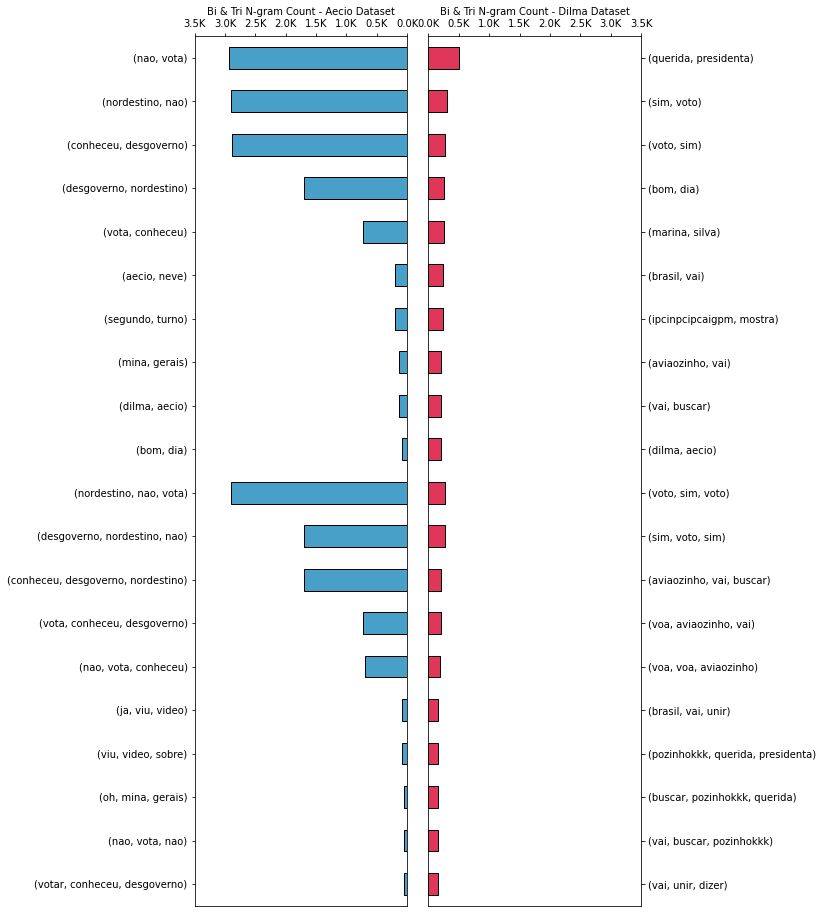

In [58]:
fig, ax=plt.subplots(1,2, figsize=(8,16), 
                     gridspec_kw={'width_ratios':[1,1], 'wspace':0.1, 'hspace':0.1})

barh_ax = ax[0]
aecio_ngrams[::-1].plot.barh(ax=barh_ax, color=barcolors[3],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK2)
barh_ax.set_xlim([0, 3500])
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('Bi & Tri N-gram Count - Aecio Dataset')
barh_ax.set_ylabel('')

barh_ax = ax[1]
dilma_ngrams[::-1].plot.barh(ax=barh_ax, color=barcolors[6],**barstyle)
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK2)
barh_ax.set_xlim([0, 3500])
barh_ax.set_xlim(barh_ax.get_xlim())
barh_ax.yaxis.tick_right()
barh_ax.set_xlabel('Bi & Tri N-gram Count - Dilma Dataset')
barh_ax.set_ylabel('')
plt.show()

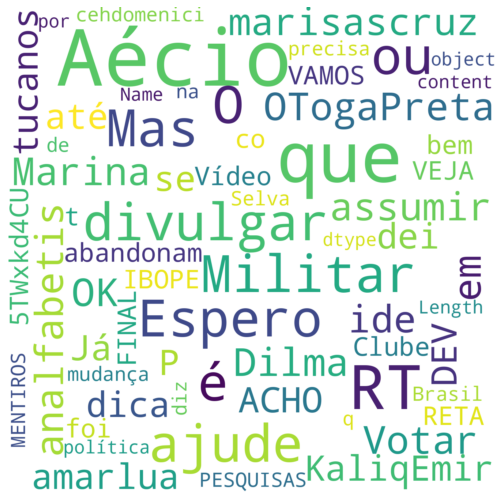

In [59]:
plt.subplots(1,1, figsize=(9,9))
wc_b = WordCloud(stopwords=STOPWORDS, 
                 background_color="white", max_words=2000,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_b.generate(str(text1.dropna()))
plt.imshow(wc_b, interpolation="bilinear")
plt.axis('off')
plt.show()

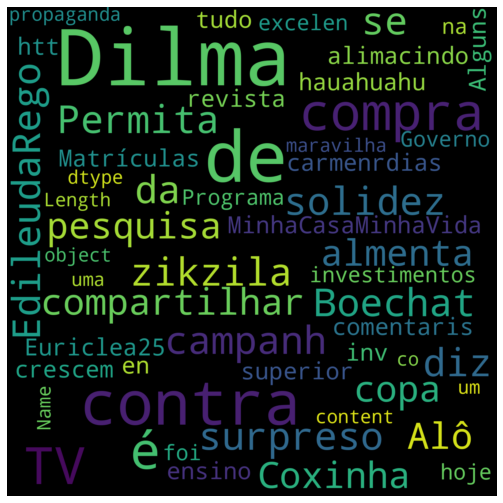

In [60]:
plt.subplots(1,1, figsize=(9,9))
wc_t = WordCloud(stopwords=STOPWORDS, 
                 background_color="black", max_words=2000,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_t.generate(str(text2.dropna()))
plt.imshow(wc_t, interpolation="bilinear")
plt.axis('off')
plt.show()

In [15]:
# Obtain sentiment scores for both datasets
sid = SentimentIntensityAnalyzer()
tweets_aecio['VADAR']=sentiment(tweets_aecio['content'])
tweets_dilma['VADAR']=sentiment(tweets_dilma['content'])
tweets_aecio['compound']  = tweets_aecio['VADAR'].apply(lambda score_dict: score_dict['compound'])
tweets_dilma['compound']  = tweets_dilma['VADAR'].apply(lambda score_dict: score_dict['compound'])
tweets_aecio['sentiment']  = tweets_aecio['compound'].apply(lambda x: 'pos' if x > 0.05 else ('neg' if x < -0.05 else 'neu'))
tweets_dilma['sentiment']  = tweets_dilma['compound'].apply(lambda x: 'pos' if x > 0.05 else ('neg' if x < -0.05 else 'neu'))

In [16]:
tweets_aecio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35339 entries, 0 to 35795
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           35339 non-null  datetime64[ns]
 1   content        35339 non-null  object        
 2   location       27695 non-null  object        
 3   username       35339 non-null  object        
 4   retweet_count  35339 non-null  int64         
 5   like_count     35339 non-null  int64         
 6   lang           35339 non-null  object        
 7   query          35339 non-null  object        
 8   crawled_date   35339 non-null  datetime64[ns]
 9   likes_norm     35339 non-null  float64       
 10  retweet_norm   35339 non-null  float64       
 11  content_clean  35339 non-null  object        
 12  VADAR          35339 non-null  object        
 13  compound       35339 non-null  float64       
 14  sentiment      35339 non-null  object        
dtypes: datetime64[ns](2

In [96]:
tweets_aecio.sample(1)

,date,content,location,username,retweet_count,like_count,lang,query,crawled_date,likes_norm,retweet_norm,content_clean,VADAR,compound,sentiment
3223,2014-10-06 01:19:16,#Aécio diz que sentimento da mudança venceu 1º turno - Reuters Brasil http://t.co/Fv5KU5wxXz,Brazil,757LiveBR,0,0,pt,#aecio,2022-06-01,0.0,0.0,"[#aécio, diz, sentimento, mudança, venceu, º, turno, reuters, brasil]","{'neg': 0.0, 'neu': 0.797, 'pos': 0.203, 'compound': 0.4215}",0.4215,pos


In [17]:
tweets_dilma[['content', 'sentiment', 'VADAR']].sample(10)

,content,sentiment,VADAR
25891,"#Dilma banca 52% do Metrô, VLT e monotrilho em SP http://t.co/guQQ7HuZur",neu,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
71603,E toda vez q mídia tenta intrigar eles se encontram: #Lula e #Dilma se encontram em BR | Instituto Lula http://t.co/RnTuO1tTxr vi @inst_lula,neu,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
78304,"Vc acha q #Dilma só foi votada pelo povo pobre do NE?Em Fortaleza, ela ganhou em TODAS as zonas eleitorais, até na área nobre.#MelhoreFHC",pos,"{'neg': 0.11, 'neu': 0.707, 'pos': 0.184, 'compound': 0.2732}"
70884,"@blogplanalto Concordo #Dilma muita gente de boa vontade quer um país mais justo e melhor, nós temos time e conseguimos sediar a #Copa.",pos,"{'neg': 0.0, 'neu': 0.63, 'pos': 0.37, 'compound': 0.8126}"
75452,@rogeriocorreia_ Pesquisa indica que o PT governa melhor! @rogeriocorreia_ #Dilma #Lula #Brasil http://t.co/KPciApB0Nk,pos,"{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.4926}"
77034,Conheça as propostas de #Dilma para a #internet #DilmaRousseff A presidente promete ampliar as medidas tomadas... http://t.co/PN8nU9yiKt,pos,"{'neg': 0.089, 'neu': 0.611, 'pos': 0.3, 'compound': 0.4215}"
47343,#Padilha terá apoio de #Dilma em agosto durante campanha em SP - http://t.co/9YftANnsP1 http://t.co/oUv4tq2OU6,pos,"{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'compound': 0.3612}"
56356,Farmácia Popular é com PT é com #Dilma http://t.co/33Izy3UBqv,pos,"{'neg': 0.0, 'neu': 0.682, 'pos': 0.318, 'compound': 0.4215}"
69080,#Dilma menciona Pnad de passagem ao defender educação infantil ... - Reuters Brasil http://t.co/mvdRbKZtQO,neg,"{'neg': 0.155, 'neu': 0.845, 'pos': 0.0, 'compound': -0.296}"
90412,"Desconto garantido! Apesar do terrorismo feito pela oposição e pela mídia, #Dilma garantiu... http://t.co/J6Lo4t458V http://t.co/wTqZHIeIhk",neg,"{'neg': 0.252, 'neu': 0.619, 'pos': 0.129, 'compound': -0.5255}"
